In [2]:
import numpy as np 
from functions import *
import structures as st
from sklearn.datasets import make_spd_matrix

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from skimage.restoration import denoise_tv_chambolle

#loading dataset

# Construct a tf.data.Dataset
(train, test), info = tfds.load(
    'mnist',
    #split=['train', 'test'],
    split = ['train[:70%]', 'train[70%:]'],
    shuffle_files=True,
    as_supervised=True,
    
    with_info=True,
)

def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

train = train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
train = train.cache()
train = train.shuffle(info.splits['train'].num_examples)
LN = int(300)
train = train.batch(LN)
train = train.prefetch(tf.data.AUTOTUNE)

LN_test = int(30)
test = test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
test = test.batch(LN_test)
test = test.cache()
test = test.prefetch(tf.data.AUTOTUNE)

for example in train.take(1):
    image, label = 1 - example[0], example[1]

for example in test.take(1):
    image2, label = 1 - example[0], example[1]

def f(alpha, V):
    total = 0
    N = len(V)
    for i in range(N):
        total += (1/(2*N)) * np.linalg.norm(div(V[i]) + dataset[i][1])
        total += alpha * TV(dataset[i][0])/N
    return total

def g(alpha):
    if alpha < 0:
        return np.inf  
    else:
        return 0

2025-03-31 19:33:26.603660: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-31 19:33:32.914387: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-31 19:33:32.969940: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-03-31 19:33:32.969978: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did n

In [3]:
from noise_functions import add_spnoise, add_noise
dataset = []
noise_level = np.sqrt(0.001)
prob = 0.3
noisies = []
for i, img in enumerate(image):
    noisy = add_spnoise(img.numpy().reshape(28,28).copy(), noise_level, prob).reshape(28,28)
    noisy = (noisy - noisy.min())/(noisy.max() - noisy.min())
    im = img.numpy().reshape(28,28)
    im = (im - im.min())/(im.max() - im.min())
    dataset.append([img.numpy().reshape(28,28), noisy])
    noisies.append(noisy)
        

dataset_test = []
noisies_test = []
for i, img in enumerate(image2):
    noisy = add_spnoise(img.numpy().reshape(28,28).copy(), noise_level, prob).reshape(28,28)
    noisy = (noisy - noisy.min())/(noisy.max() - noisy.min())
    im = img.numpy().reshape(28,28)
    im = (im - im.min())/(im.max() - im.min())
    dataset_test.append([img.numpy().reshape(28,28), noisy])
    noisies_test.append(noisy)

In [4]:
alpha0 = 20
V0 = []
for _ in dataset:
    V0.append(im_dual(_[1]))

In [11]:
iteration = 0 
max_iterations = 30
V = V0
Prev_V = [0 * v for v in V]
alpha = alpha0
N = len(V)
Lambda = 1
L = 10/N
eps = 1

alphas = []
re = []
initial_error = f(alpha, V)
errors = [initial_error]
prev_alpha = 10000 
diff = 1
theta_k = 0

while iteration < max_iterations and diff > 1e-4:
    Sigma = 0
    for i in range(N):
        Sigma += TV(dataset[i][0]) - TV(div(V[i]) + dataset[i][1])
    alpha_tilde_lhs = 1/(2 * Lambda) * (Lambda * alpha - Sigma/N)
    alpha_tilde = max(alpha_tilde_lhs, eps)
    V_tilde = []
    grad_v = 0 
    for i in range(N):
        init_v = im_dual(div(V[i]) + dataset[i][1])
        v_tilde = init_v
        for s in range(v_tilde.shape[1]):
            for t in range(v_tilde.shape[2]):
                vector = np.array([v_tilde[0, s, t], v_tilde[1, s, t]])
                norm = np.linalg.norm(vector, 2)
                if norm != 0:
                    if v_tilde[0, s, t] > alpha_tilde:
                        v_tilde[0, s, t] = (v_tilde[0,s,t]/norm) * alpha_tilde
                    else:
                        v_tilde[0, s, t] = 0
                        
                    if v_tilde[1, s, t] > alpha_tilde:
                        v_tilde[1, s, t] = (v_tilde[1,s,t]/norm) * alpha_tilde
                    else:
                        v_tilde[1, s, t] = 0
        V_tilde.append(v_tilde)
        grad_v += np.trace(init_v[0].T @ (V[i][0] - V_tilde[i][0]))
        grad_v += np.trace(init_v[1].T @ (V[i][1] - V_tilde[i][1]))
    grad_v = grad_v / N 
    
    grad_alpha = 0 
    for i in range(N):
        grad_alpha += TV(dataset[i][0])
    grad_alpha = grad_alpha / N 
    
    Df = 0 
    for i in range(N):
        Df += L * alpha * alpha_tilde 
    theta_k = min(1, (grad_v + grad_alpha)/(L * Df))
    for i in range(N):
        V[i] = V[i] + theta_k * (V_tilde[i] - V[i])
    alpha = alpha + theta_k * (alpha_tilde - alpha)
    
    error = f(alpha, V)
    if (iteration + 1) % 1 == 0:
        print(f'Iteration {iteration + 1}, Alpha/Tilde: {round(alpha, 2)} | {round(alpha_tilde, 2)}, Error: {round(error/N, 3)}, Theta: {round(theta_k, 3)}')
    errors.append(error/N)
    alphas.append(alpha)
    diff = abs(prev_alpha - alpha)
    prev_alpha = alpha
    iteration += 1 

Iteration 1, Alpha/Tilde: 11.2 | 11.2, Error: 3.084, Theta: 1
Iteration 2, Alpha/Tilde: 6.81 | 6.81, Error: 1.889, Theta: 1
Iteration 3, Alpha/Tilde: 4.61 | 4.61, Error: 1.292, Theta: 1
Iteration 4, Alpha/Tilde: 3.51 | 3.51, Error: 0.993, Theta: 1
Iteration 5, Alpha/Tilde: 2.96 | 2.96, Error: 0.844, Theta: 1
Iteration 6, Alpha/Tilde: 2.68 | 2.68, Error: 0.769, Theta: 1
Iteration 7, Alpha/Tilde: 2.55 | 2.55, Error: 0.732, Theta: 1
Iteration 8, Alpha/Tilde: 2.48 | 2.48, Error: 0.713, Theta: 1
Iteration 9, Alpha/Tilde: 2.44 | 2.44, Error: 0.704, Theta: 1
Iteration 10, Alpha/Tilde: 2.43 | 2.43, Error: 0.699, Theta: 1
Iteration 11, Alpha/Tilde: 2.42 | 2.42, Error: 0.697, Theta: 1
Iteration 12, Alpha/Tilde: 2.41 | 2.41, Error: 0.696, Theta: 1
Iteration 13, Alpha/Tilde: 2.41 | 2.41, Error: 0.695, Theta: 1
Iteration 14, Alpha/Tilde: 2.41 | 2.41, Error: 0.695, Theta: 1
Iteration 15, Alpha/Tilde: 2.41 | 2.41, Error: 0.695, Theta: 1
Iteration 16, Alpha/Tilde: 2.41 | 2.41, Error: 0.694, Theta: 1
I

In [12]:
errors_test = []
for alpha in alphas:
    rec_error = 0
    for i in range(len(dataset_test)):
        true = dataset_test[i][0]
        noisy = dataset_test[i][1]
        denoised = denoise_tv_chambolle(noisy, 1/alpha)
        rec_error += 0.5 * np.linalg.norm(denoised - true) ** 2
    errors_test.append(rec_error/len(dataset_test))

In [13]:
errors_test[-1]

13.45560583408716

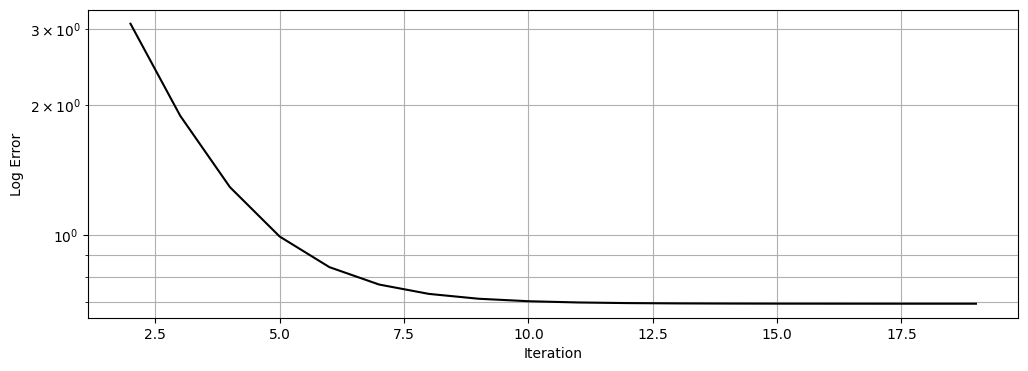

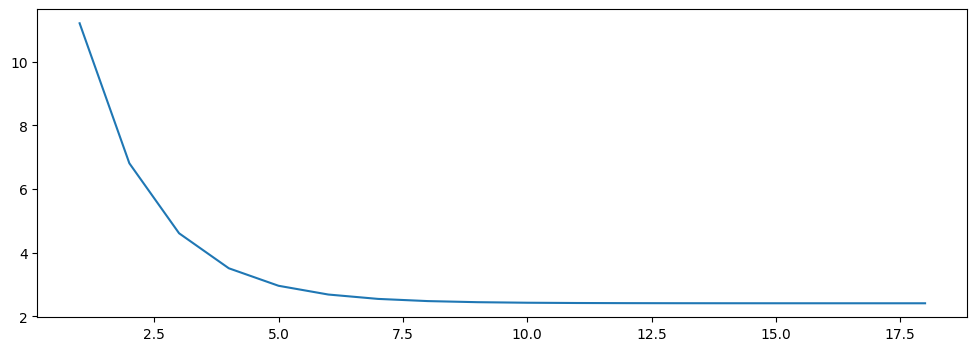

In [14]:
plt.figure(figsize = (12,4))
plt.plot([_ +1 for _ in range(1,iteration+1)], errors[1:], color = 'black')
plt.yscale('log')
plt.ylabel('Log Error')
plt.xlabel('Iteration')
plt.grid(True, which="both", ls="-")
plt.show()

'''
plt.figure(figsize = (12,4))
plt.plot([_ + 1 for _ in range(iteration)], re, label = 'Training Set Recovery Error')
plt.plot([_ + 1 for _ in range(iteration)], errors_test, label = 'Test Set Recovery Error')
plt.legend()
plt.show()
'''

plt.figure(figsize = (12,4))
plt.plot([_ + 1 for _ in range(iteration)], alphas)
plt.show()

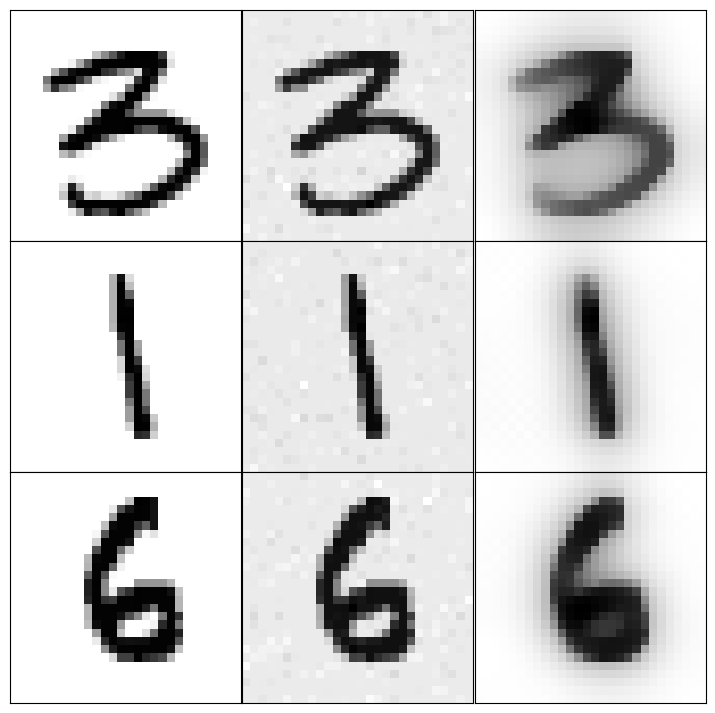

In [17]:
x = 1
y = 12
z = 21

fig, axes = plt.subplots(nrows = 3, ncols = 3,figsize=(18,9), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0, wspace=-0.75))
axes[0,0].imshow(dataset_test[x][0], cmap = 'grey')
axes[1,0].imshow(dataset_test[y][0], cmap = 'grey')
axes[2,0].imshow(dataset_test[z][0], cmap = 'grey')

axes[0,1].imshow(dataset_test[x][1], cmap = 'grey')
axes[1,1].imshow(dataset_test[y][1], cmap = 'grey')
axes[2,1].imshow(dataset_test[z][1], cmap = 'grey')

axes[0,2].imshow(denoise_tv_chambolle(dataset_test[x][1], 1/alpha), cmap = 'grey')
axes[1,2].imshow(denoise_tv_chambolle(dataset_test[y][1], 1/alpha), cmap = 'grey')
axes[2,2].imshow(denoise_tv_chambolle(dataset_test[z][1], 1/alpha), cmap = 'grey')